In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import napari
import patoolib
import zipfile
import os
import re
import tqdm
from monai.transforms import (
    Compose, LoadImaged, Spacingd, NormalizeIntensityd, SpatialPadd,
    RandCropByPosNegLabeld, RandRotated, RandFlipd, RandAdjustContrastd,
    RandShiftIntensityd, RandGaussianNoised, RandScaleIntensityd, RandZoomd,
    RandAffined, AsDiscrete
)
from monai import (
    data,
    transforms,
)
from cldice import soft_dice_cldice, soft_dice
from unet_block import UNet3D
from monai.data import (
    ArrayDataset,
    DataLoader,
    create_test_image_3d,
    decollate_batch,
)
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import torch.optim as optim

#### Look at the data

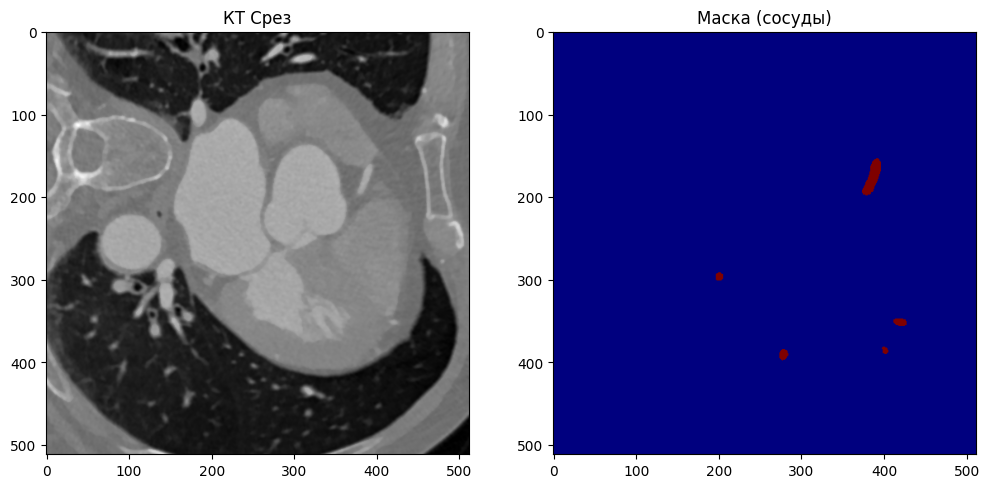

In [2]:
# Путь к файлу (замените на свой)
image_path = './archive/1-200/1.img.nii.gz'
label_path = './archive/1-200/1.label.nii.gz'

# Загрузка
img = nib.load(image_path)
label = nib.load(label_path)

# Преобразование в numpy-массив
img_data = img.get_fdata()
label_data = label.get_fdata()

# Выбор центрального среза по оси Z
slice_idx = img_data.shape[2] // 2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("КТ Срез")
plt.imshow(img_data[:, :, slice_idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Маска (сосуды)")
plt.imshow(label_data[:, :, slice_idx], cmap='jet')

plt.show()

In [3]:
# Запуск просмотрщика
# viewer = napari.Viewer()

# # Добавление КТ-снимка
# viewer.add_image(img_data, name='CTA Image', colormap='gray')

# # Добавление маски сегментации поверх снимка
# viewer.add_labels(label_data.astype(int), name='Vessel Mask')

# # Инструкция: используйте ползунок внизу для перемещения по срезам
# napari.run()

##### Готовим данные для нейросети

In [4]:
def download_data(path, dtype):
    for dir in path:
        start, end = dir.split('-')
        img_path = [f'./archive/{dir}/{i}.img.nii.gz' for i in range(int(start), int(end)+1)]
        segs_path += [f'./archive/{dir}/{i}.label.nii.gz' for i in range(int(start), int(end)+1)]

        imgs = torch.tensor([nib.load(img_file).get_data() for img_file in img_path], dtype=torch.float16)
        segs = torch.tensor([nib.load(segs_file).get_data() for segs_file in segs_path], dtype=torch.float16)
        

In [3]:
dirs = ['1-200'] # test dataset
# dirs = ['1-200', '201-400', '401-600', '601-800', '801-1000']

images, segs = [], []
for dir in dirs:
    start, end = dir.split('-')
    images += [f'./archive/{dir}/{i}.img.nii.gz' for i in range(int(start), int(end)+1)]

for dir in dirs:
    start, end = dir.split('-')
    segs += [f'./archive/{dir}/{i}.label.nii.gz' for i in range(int(start), int(end)+1)]

In [4]:
dataset = [{"image": img, "label": lbl} for img, lbl in zip(images, segs)]

In [5]:
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_files, validation_files = random_split(dataset, [train_size, val_size])

In [6]:
roi = (96, 96, 96)

base_transform = [transforms.LoadImaged(keys=["image", "label"], ensure_channel_first=True), # LoadImaged - 
        transforms.SpatialPadd(keys=["image", "label"], spatial_size=roi), # SpatialPadd - заполнить изображение до заданного roi
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), # NormalizeIntensityd - стандартная нормализация значений каналов изображения 
        transforms.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"))] # Spacingd - 

num_crop_samples = 4
train_transform = [transforms.RandCropByPosNegLabeld(
                           keys=["image", "label"], 
                           label_key="label",
                           spatial_size=roi,
                           num_samples=num_crop_samples,
                           image_key="image",
                           allow_smaller=True)] 

In [7]:
aug_transform = [    
    # === Геометрические аугментации ===
    RandRotated(
        keys=["image", "label"],
        range_x=np.pi/6,
        range_y=np.pi/6,
        range_z=np.pi/6,
        prob=0.3,
        mode=("bilinear", "nearest"),
        align_corners=True
    ),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.3),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.3),
    RandFlipd(keys=["image", "label"], spatial_axis=2, prob=0.3),

    # === Дополнительные геометрические трансформации ===
    RandZoomd(
        keys=["image", "label"],
        min_zoom=0.9,
        max_zoom=1.1,
        mode=("trilinear", "nearest"),
        align_corners=(True, None),
        prob=0.3
    ),
    RandAffined(
        keys=["image", "label"],
        rotate_range=(0.1, 0.1, 0.1),
        scale_range=(0.1, 0.1, 0.1),
        translate_range=(5, 5, 5),
        prob=0.3,
        mode=("bilinear", "nearest"),
        padding_mode="border"
    ),

    # === Фотометрические трансформации (только для изображения) ===
    RandAdjustContrastd(
        keys=["image"],
        gamma=(0.7, 1.5),
        prob=0.3
    ),
    RandShiftIntensityd(
        keys=["image"],
        offsets=0.1,
        prob=0.3
    ),
    RandScaleIntensityd(
        keys=["image"],
        factors=0.1,
        prob=0.3
    ),
    RandGaussianNoised(
        keys=["image"],
        std=0.05,
        prob=0.3
    ),]

In [8]:
train_transform = transforms.Compose(base_transform + train_transform + aug_transform)

train_ds = data.Dataset(data=train_files, transform=train_transform)

train_loader = data.DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

In [9]:
val_transform = transforms.Compose(base_transform)

val_ds = data.Dataset(data=validation_files, transform=val_transform)

val_loader = data.DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [10]:
item = next(iter(train_loader))
print(item['image'].shape)

item = next(iter(val_loader))
print(item['image'].shape)

torch.Size([4, 1, 96, 96, 96])
torch.Size([1, 1, 187, 187, 138])


#### Model training and validation

In [ ]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = UNet3D(in_channels=1, out_channels=2, final_sigmoid=False, f_maps=64, num_levels=4)
# model = UNet(spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64),
#     strides=(2, 2, 2),
#     num_res_units=2,
#     kernel_size=3,
#     up_kernel_size=3,
#     norm='batch').to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = soft_dice_cldice(alpha=0.3)
scaler = torch.amp.GradScaler()

In [ ]:
device=None
device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    print(f"Размер модели (только веса): {total_params * 4 / (1024**2):.2f} MB")

count_parameters(model)

Всего параметров: 4,081,300
Обучаемых параметров: 4,081,300
Размер модели (только веса): 15.57 MB


In [ ]:
def plot_train_history(train_epoch_losses, val_epoch_losses, val_dice_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
    epochs = range(1, len(train_epoch_losses) + 1)
    ax1.plot(epochs, train_epoch_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, val_epoch_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График Dice Score
    ax2.plot(epochs, val_dice_scores, 'g-', label='Val Dice Score', linewidth=2)
    ax2.set_title('Validation Dice Score', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Dice Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def validation(model, loss, val_loader):
    with torch.no_grad():
        epoch_loss = 0.0
        dice_loss = 0.0

        model.eval()
        for batch_data in tqdm.tqdm(val_loader):
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
   
            outputs = model(inputs)
            outputs = outputs[:, -1, :, :, :]
            loss = loss_function(labels, outputs)
            
            epoch_loss += loss.item()
            dice_loss += soft_dice(labels, outputs).item()

    metric = 1 - dice_loss / len(val_loader)
    return epoch_loss / len(val_loader), metric


def train(model, loss, optimizer, train_loader, val_loader, epochs, plot_loss):
    train_epoch_losses = []
    val_epoch_losses = []
    val_dice_scores = []
    for epoch in range(epochs):
        step = 0
        epoch_loss = 0.0
        dice_loss = 0.0
        for batch_data in tqdm.tqdm(train_loader):
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            
            optimizer.zero_grad()
            # with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            outputs = outputs[:, -1, :, :, :]
            loss = loss_function(labels, outputs)
                
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            dice_loss += soft_dice(labels, outputs).item()
            
            if step % 20 == 0:
                print(f"  Шаг {step}, Loss: {epoch_loss / step:.4f}")
                print(f"  Шаг {step}, Dice Loss: {dice_loss / step:.4f}")
        train_epoch_losses.append(epoch_loss / len(train_loader))

        val_epoch_loss, val_mertic = validation(model, loss_function, val_loader)
        val_epoch_losses.append(val_epoch_loss)
        val_dice_scores.append(val_mertic)

        if plot_loss:
            plot_train_history(train_epoch_losses, val_epoch_losses, val_dice_scores)

    torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
train(model, loss_function, optimizer, train_loader, val_loader, 5, True)

#### Look at the result

In [ ]:
with torch.no_grad():
    model.eval()
    batch = next(iter(val_loader))
    img, label = batch['image'], batch["label"]
    img = img.to(device)
    pred = model(img)

    pred = torch.argmax(pred[0], dim=0).cpu().numpy()
    label = label[0].cpu().squeeze().numpy()
    img = img[0].cpu().squeeze().numpy()

In [ ]:
# Выбор центрального среза по оси Z
slice_idx = img.shape[2] // 2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Маска (сосуды)")
plt.imshow(label[:, :, slice_idx], cmap='jet')

plt.subplot(1, 2, 2)
plt.title("Предсказанная маска (сосуды)")
plt.imshow(pred[:, :, slice_idx], cmap='jet')

plt.show()

In [ ]:
# Запуск просмотрщика
viewer = napari.Viewer()

# Добавление КТ-снимка
viewer.add_image(img, name='CTA Image', colormap='gray')

# Добавление маски сегментации поверх снимка
viewer.add_labels(pred.astype(int), name='Vessel Mask pred')
viewer.add_labels(label.astype(int), name='Vessel Mask')

# Инструкция: используйте ползунок внизу для перемещения по срезам
napari.run()